# **Analytics Module**

- Analytics module has been developed in power bi , this notebook helps for the data analysis and exporting the data in the desired format.

In [402]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## **Loading the data**



- We need `price_per_sqft` , so We are loading the cleaned data from the feature engineering module after imputing the missing values.


In [403]:
input = '../data/clean-data/flats-house-cleaned-v4.csv'

df = pd.read_csv(input)
print("Shape of the dataframe: ",df.shape)
df.head()   

Shape of the dataframe:  (3540, 18)


,property_type,society,sector,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,agePossession,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,flat,emaar mgf palm hills,sector 77,1.50,12744.0,3,3,3,4.0,Relatively New,1310.0,0,0,0,0,0,2,97
1,flat,raheja vedaanta,sector 108,0.85,4637.0,3,3,2,2.0,Relatively New,1500.0,0,1,0,0,0,0,65
2,flat,511 sarahah tower,sector 12,0.60,8333.0,2,2,1,0.0,New Property,800.0,0,0,0,1,0,1,0
3,flat,laxmi pareena,sector 99a,0.30,6667.0,2,1,0,12.0,New Property,500.0,0,0,0,0,0,0,0
4,flat,emaar gurgaon greens,sector 102,1.55,9394.0,3,4,3,7.0,Relatively New,1315.0,0,1,0,0,0,2,152


In [404]:
print("Unique sectors: ",df['sector'].value_counts().shape)
df['sector'].value_counts()

Unique sectors:  (125,)


sector
sohna road       152
sector 102       107
sector 85        107
sector 92         98
sector 69         93
                ... 
garhi harsaru      2
bhim nagar         2
sector 27          2
sector 37          1
sector 17a         1
Name: count, Length: 125, dtype: int64

---

**NOTE:**
- We need `sector` location data , for that we have manually scraped the sector location(longitude,latitude) from the google results and stored in `sector-location.csv` file.

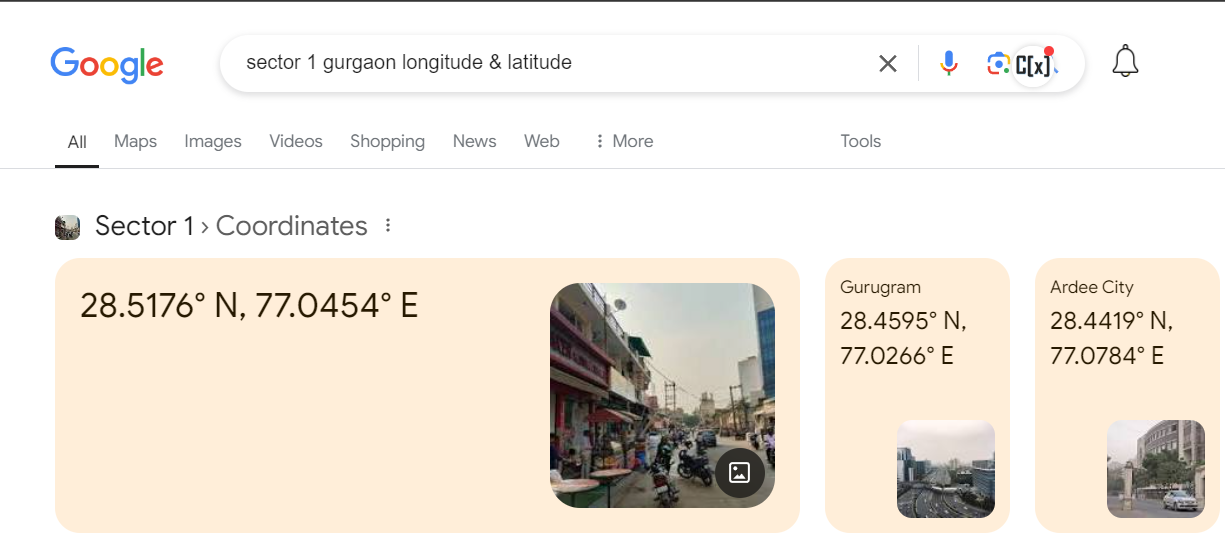

In [405]:
sector_data = '../data/clean-data/sector-location.csv'

sector_df = pd.read_csv(sector_data)
print("Shape of the sector dataframe: ",sector_df.shape)
sector_df.head()

Shape of the sector dataframe:  (129, 2)


,sector,coordinates
0,sector 1,"28.3663° N, 76.9456° E"
1,sector 2,"28.5095° N, 77.0320° E"
2,sector 3,"28.4909° N, 77.0176° E"
3,sector 4,"28.4738° N, 77.0107° E"
4,sector 5,"28.4794° N, 77.0176° E"


In [406]:
# cleaning the coordinates column
sector_df['latitude'] = sector_df['coordinates'].str.split(',').str.get(0).str.split('°').str.get(0).astype('float')
sector_df['longitude'] = sector_df['coordinates'].str.split(',').str.get(1).str.split('°').str.get(0).astype('float')

sector_df.head()

,sector,coordinates,latitude,longitude
0,sector 1,"28.3663° N, 76.9456° E",28.3663,76.9456
1,sector 2,"28.5095° N, 77.0320° E",28.5095,77.0320
2,sector 3,"28.4909° N, 77.0176° E",28.4909,77.0176
3,sector 4,"28.4738° N, 77.0107° E",28.4738,77.0107
4,sector 5,"28.4794° N, 77.0176° E",28.4794,77.0176


### **Merging the Sector Coordinate data with the main dataframe to get longitude and latitude data**

In [407]:
df_with_location = df.merge(sector_df, on='sector')

print("Shape of the new dataframe: ",df_with_location.shape)
df_with_location.head(2)

Shape of the new dataframe:  (3222, 21)


,property_type,society,sector,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,agePossession,...,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,coordinates,latitude,longitude
0,flat,emaar mgf palm hills,sector 77,1.50,12744.0,3,3,3,4.0,Relatively New,...,0,0,0,0,0,2,97,"28.3801° N, 76.9845° E",28.3801,76.9845
1,flat,raheja vedaanta,sector 108,0.85,4637.0,3,3,2,2.0,Relatively New,...,0,1,0,0,0,0,65,"28.5134° N, 76.9830° E",28.5134,76.9830


### **Grouping the data by sector and getting the mean of the price, price_per_sqft, built_up_area, latitude, and longitude**

In [408]:
group_df = df_with_location.groupby('sector').agg({
    'price': 'mean',
    'price_per_sqft': 'mean',
    'built_up_area': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
})

group_df.head()

,price,price_per_sqft,built_up_area,latitude,longitude
sector,,,,,
gwal pahari,3.192222,9585.777778,3056.166667,28.4484,77.0210
manesar,1.062500,6702.250000,1878.600000,28.3515,76.9428
sector 1,1.860000,8249.833333,2327.833333,28.3663,76.9456
sector 102,1.696636,10603.822430,1556.130841,28.4750,76.9715
sector 103,1.495000,7445.785714,1865.428571,28.4949,76.9845


### **1. Creating a map of the sectors with the average price per sqft**

In [409]:
import folium

# Function to determine marker color based on price_per_sqft
def get_marker_color(price_per_sqft):
    if price_per_sqft < 7000:
        return 'green'
    elif 7000 <= price_per_sqft < 10000:
        return 'orange'
    else:
        return 'red'

# Create a base map
m = folium.Map(location=[group_df['latitude'].mean(), group_df['longitude'].mean()], zoom_start=11.5)

# Add markers directly to the map
for idx, row in group_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"<b>Sector:</b> {idx}<br><b>Avg. Price per sqft:</b> {row['price_per_sqft']}<br><b>Avg Built up area:</b> {row['built_up_area']}", max_width=300),
        icon=folium.Icon(color=get_marker_color(row['price_per_sqft']), icon='info-sign')
    ).add_to(m)

# Add a legend to the map
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 150px; height: 150px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Price per sqft</b><br>
    <i class="fa fa-map-marker fa-2x" style="color:green"></i> < 7000<br>
    <i class="fa fa-map-marker fa-2x" style="color:orange"></i> 7000 - 9999<br>
    <i class="fa fa-map-marker fa-2x" style="color:red"></i> >= 10000<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
# m.save('sector-map.html')
m

---

### **2. Creating a word cloud of the features of the properties**

- Loading this data to get ammenities list of each sector

In [410]:
df_with_word = pd.read_csv('../data/clean-data/flats-house-cleaned-v1.csv')
len(df_with_word['sector'].unique())

125

#### WordCloud: generating a word cloud to visualize the amenities available in whole Gurgaon, highlighting the common ones.

In [411]:
df_with_word = df_with_word[['sector','features']]
df['sector']. value_counts()

sector
sohna road       152
sector 102       107
sector 85        107
sector 92         98
sector 69         93
                ... 
garhi harsaru      2
bhim nagar         2
sector 27          2
sector 37          1
sector 17a         1
Name: count, Length: 125, dtype: int64

In [412]:
df_with_location['sector'].value_counts()

sector
sector 102    107
sector 85     107
sector 92      98
sector 69      93
sector 90      89
             ... 
sector 73       3
sector 88b      3
sector 27       2
sector 37       1
sector 17a      1
Name: count, Length: 105, dtype: int64

In [413]:
wordcloud_df = df_with_word[['sector', 'features']]


#### Preparing features(ammenities) in gurgaon 

In [414]:
import ast
big_list = []
for item in wordcloud_df['features'].dropna().apply(ast.literal_eval):
    big_list.extend(item)

feature_text = ' '.join(big_list)
feature_text


'Security / Fire Alarm Feng Shui / Vaastu Compliant Lift(s) Maintenance Staff Water Storage Recently Renovated Piped-gas Visitor Parking Swimming Pool Park Natural Light Internet/wi-fi connectivity Airy Rooms Spacious Interiors Shopping Centre Fitness Centre / GYM Waste Disposal Club house / Community Center Water softening plant Power Back-up Feng Shui / Vaastu Compliant Intercom Facility Lift(s) Swimming Pool Maintenance Staff Park Security Personnel Shopping Centre Fitness Centre / GYM Club house / Community Center Rain Water Harvesting Centrally Air Conditioned Security / Fire Alarm Feng Shui / Vaastu Compliant Intercom Facility Lift(s) High Ceiling Height Maintenance Staff Water Storage Separate entry for servant room No open drainage around Piped-gas Internet/wi-fi connectivity Recently Renovated Visitor Parking Swimming Pool Park Security Personnel Natural Light Airy Rooms Spacious Interiors Low Density Society Waste Disposal Rain Water Harvesting Water softening plant Shopping 

### saving the feature_text as pickle and json file

In [415]:

import json


# Save as JSON , it can be used to create a wordcloud in power bi
with open('feature_text.json', 'w') as json_file:
    json.dump(feature_text, json_file)

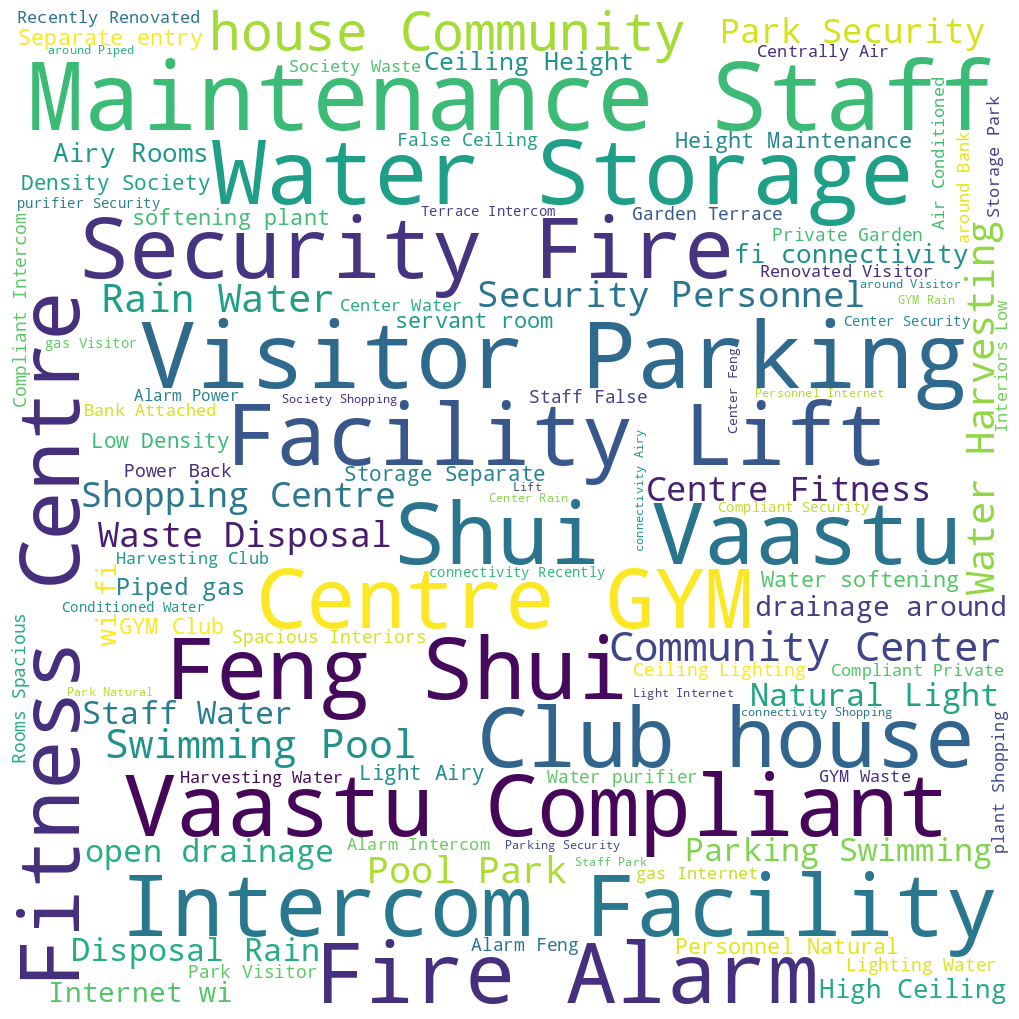

In [416]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set the font family to a more visually appealing one
plt.rcParams["font.family"] = "DejaVu Sans"

# Define additional stopwords
additional_stopwords = set(['s', 'property', 'features'])

# Create the wordcloud object with more customization for beauty
wordcloud = WordCloud(width=1000, height=1000, 
                      background_color='white', 
                      stopwords=STOPWORDS.union(additional_stopwords), 
                      colormap='viridis', 
                      contour_color='steelblue', 
                      contour_width=3, 
                      min_font_size=12).generate(feature_text)

# Plot the wordcloud
plt.figure(figsize=(10, 10), facecolor=None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad=0) 
# plt.savefig('beautiful_wordcloud.png')  # Save the picture
plt.show()

---

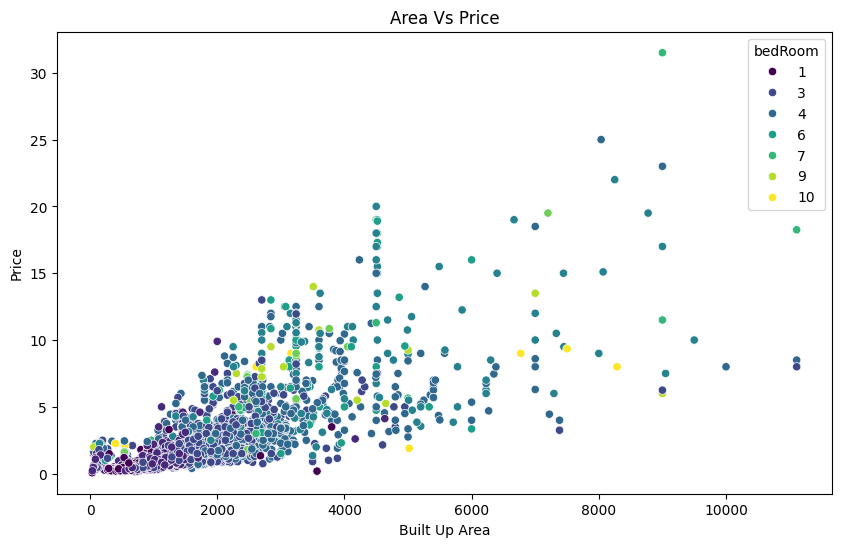

In [417]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="built_up_area", y="price", hue="bedRoom", palette="viridis")

# Add title and labels
plt.title("Area Vs Price")
plt.xlabel("Built Up Area")
plt.ylabel("Price")

# Show the plot
plt.show()

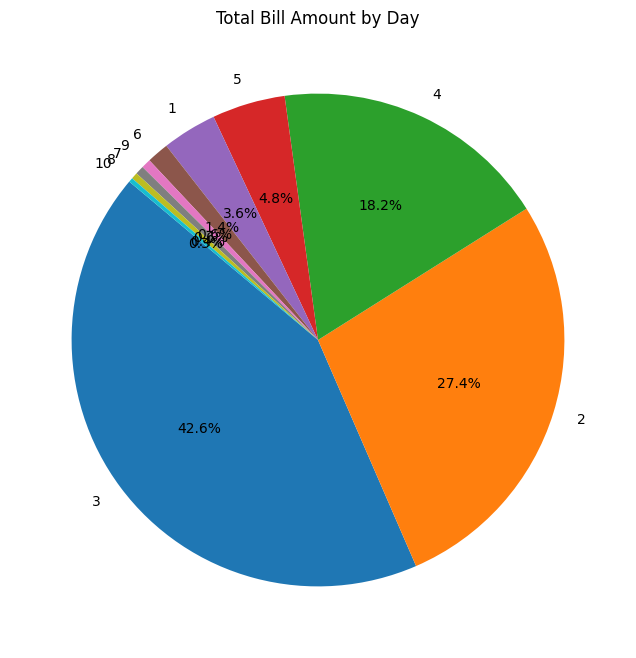

In [418]:
import matplotlib.pyplot as plt

# Data for the pie chart
bedroom_counts = df['bedRoom'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(bedroom_counts, labels=bedroom_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Bill Amount by Day')
plt.show()

In [419]:
# fig = px.pie(df, names='bedRoom', title='Total Bill Amount by Day')

# # Show the plot
# fig.show()

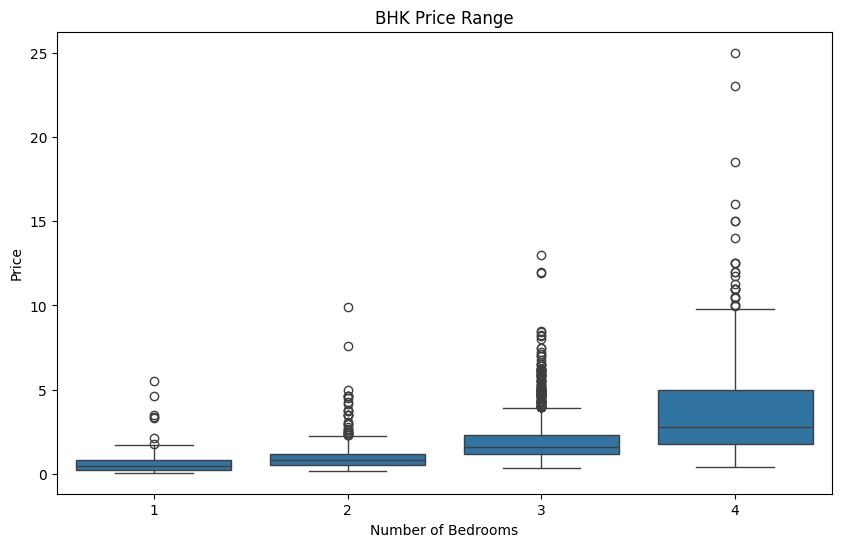

In [420]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame
temp_df = df[df['bedRoom'] <= 4]

# Create side-by-side boxplots of the price by bedRoom
plt.figure(figsize=(10, 6))
sns.boxplot(x='bedRoom', y='price', data=temp_df)

# Add title and labels
plt.title('BHK Price Range')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')

# Show the plot
plt.show()

In [421]:
# temp_df = df[df['bedRoom'] <= 4]
# # Create side-by-side boxplots of the total bill amounts by day
# fig = px.box(temp_df, x='bedRoom', y='price', title='BHK Price Range')

# # Show the plot
# fig.show()


In [422]:
# sns.distplot(df[df['property_type'] == 'house']['price'])
# sns.distplot(df[df['property_type'] == 'flat']['price'])

In [423]:
# df_with_location['sector'].unique().tolist().insert(0,'overall')

**End**